### Loading packages

In [1]:
# These two lines are necessary only if gempy is not installed
import sys, os
sys.path.append("../../..")
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cuda"

import theano

# Importing gempy
import gempy as gp

# Embedding matplotlib figures into the notebooks
%matplotlib inline

# Aux imports
import numpy as np
import pandas as pn
import matplotlib.pyplot as plt


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'/tmp/try_flags_j4fyx0yd.c:4:10: fatal error: cudnn.h: No such file or directory\n #include <cudnn.h>\n          ^~~~~~~~~\ncompilation terminated.\n'
Mapped name None to device cuda: GeForce RTX 2080 (0000:01:00.0)


### Loading data from repository:

With pandas we can do it directly from the web and with the right args we can directly tidy the data in gempy style:

In [2]:
dfs = []
for letter in 'ABCD':
    dfs.append(pn.read_csv('https://raw.githubusercontent.com/Loop3D/ImplicitBenchmark/master/Claudius/'+
                           letter+'Points.csv', sep=';',
                         names=['X', 'Y', 'Z', 'surface', 'cutoff'], header=0)[::1])
## Add fault:
dfs.append(pn.read_csv('https://raw.githubusercontent.com/Loop3D/ImplicitBenchmark/master/Claudius/Fault.csv',
                      names=['X', 'Y', 'Z', 'surface'], header=0))
surface_points = pn.concat(dfs, sort=True)
#surface_points['surface'] = surface_points['surface'].astype('str')
surface_points.reset_index(inplace=True, drop=False)
surface_points.tail()

,index,X,Y,Z,cutoff,surface
20042,88,551099.250977,7.817652e+06,-10466.863281,NaN,Claudius_fault
20043,89,551160.807495,7.817503e+06,-10356.463867,NaN,Claudius_fault
20044,90,551131.898438,7.817659e+06,-10383.323242,NaN,Claudius_fault
20045,91,551164.412476,7.817654e+06,-10299.957031,NaN,Claudius_fault
20046,92,551197.192139,7.817647e+06,-10216.820312,NaN,Claudius_fault


How many points are per surface

In [3]:
surface_points.groupby('surface').count()

,index,X,Y,Z,cutoff
surface,,,,,
0,5000,5000,5000,5000,5000
60,5000,5000,5000,5000,5000
250,5000,5000,5000,5000,5000
330,4954,4954,4954,4954,4954
Claudius_fault,93,93,93,93,0


Now we do the same with the orientations:

In [5]:
dfs = []

for surf in [0.0, 330.0]:
    o = pn.read_csv('https://raw.githubusercontent.com/Loop3D/ImplicitBenchmark/master/Claudius/Dips.csv', sep=';',
                    names=['X', 'Y', 'Z', 'G_x', 'G_y', 'G_z', '-'], header=1)

    # Orientation needs to belong to a surface. This is mainly to categorize to which series belong and to
    # use the same color
    o['surface'] = surf
    dfs.append(o)
orientations = pn.concat(dfs, sort=True)
orientations.reset_index(inplace=True, drop=False)

orientations.tail()

,index,-,G_x,G_y,G_z,X,Y,Z,surface
43,19,0.976692,0.187195,0.138165,-0.972558,550989.3105,7817210.527,-9782.967773,330.0
44,20,0.248187,-0.080561,-0.043063,-0.995819,550939.3105,7821227.309,-9958.425781,330.0
45,21,0.649480,-0.161328,0.075208,-0.984031,549276.8105,7820682.980,-9985.125977,330.0
46,22,0.050025,-0.012103,-0.153309,-0.988104,548976.8105,7820345.121,-9974.265625,330.0
47,23,0.759421,0.369490,-0.187053,-0.910213,549764.3105,7820457.738,-9901.208984,330.0


### Data initialization:

Suggested size of the axis-aligned modeling box: 
Origin: 548800 7816600 -8400
Maximum: 552500 7822000 -11010

Suggested resolution: 100m x 100m x -90m (grid size 38 x 55 x 30)

In [6]:
# Number of voxels:
np.array([38, 55, 30]).prod()

62700

In [8]:
geo_model = gp.create_model('Claudius')
# Importing the data from csv files and settign extent and resolution
geo_model = gp.init_data(geo_model, 
                         extent= [548800,552500,7816600,7822000,-11010, -8400], resolution = [38, 55, 30],
                         surface_points_df=surface_points, orientations_df=orientations, surface_name='surface',
                         add_basement=True)

Active grids: ['regular']


We are going to increase the smoothness (nugget) of the data to increase the conditional number of the matrix:

In [15]:
geo_model.modify_surface_points(geo_model.surface_points.df.index, smooth=0.1).df.tail()

,X,Y,Z,X_r,Y_r,Z_r,surface,series,id,order_series,smooth
20042,551099.250977,7.817652e+06,-10466.863281,0.541549,0.350372,0.436625,Claudius_fault,Default series,5,1,0.1
20043,551160.807495,7.817503e+06,-10356.463867,0.547415,0.336161,0.447146,Claudius_fault,Default series,5,1,0.1
20044,551131.898438,7.817659e+06,-10383.323242,0.544660,0.351065,0.444586,Claudius_fault,Default series,5,1,0.1
20045,551164.412476,7.817654e+06,-10299.957031,0.547759,0.350518,0.452531,Claudius_fault,Default series,5,1,0.1
20046,551197.192139,7.817647e+06,-10216.820312,0.550882,0.349832,0.460453,Claudius_fault,Default series,5,1,0.1


Also the original poles are pointing downwards. We can change the direction by calling the following:

In [14]:
geo_model.modify_orientations(geo_model.orientations.df.index, polarity=-1).df.tail()


,X,Y,Z,X_r,Y_r,Z_r,G_x,G_y,G_z,dip,azimuth,polarity,surface,series,id,order_series,smooth
43,550989.3105,7817210.527,-9782.967773,0.531072,0.308282,0.501798,-0.187194,-0.138164,0.972558,166.546239,53.569684,-1,330,Default series,4,1,0.01
44,550939.3105,7821227.309,-9958.425781,0.526307,0.691072,0.485078,0.080561,0.043063,0.995819,174.758819,241.873756,-1,330,Default series,4,1,0.01
45,549276.8105,7820682.980,-9985.125977,0.367875,0.639198,0.482533,0.161328,-0.075208,0.984031,169.746878,294.994025,-1,330,Default series,4,1,0.01
46,548976.8105,7820345.121,-9974.265625,0.339285,0.607001,0.483568,0.012103,0.153310,0.988104,171.153539,184.513861,-1,330,Default series,4,1,0.01
47,549764.3105,7820457.738,-9901.208984,0.414332,0.617733,0.490530,-0.369491,0.187053,0.910213,155.534803,116.850651,-1,330,Default series,4,1,0.01


We need an orientation per series/fault. The faults does not have orientation so the easiest is to create an orientation from the surface points availablle:

In [16]:
fault_idx = geo_model.surface_points.df.index[geo_model.surface_points.df['surface'] =='Claudius_fault']
gp.set_orientation_from_surface_points(geo_model, fault_idx).df.tail()

../../../gempy/core/data.py:1675: UserWarning: If pole_vector and orientation are passed pole_vector is used/
  warnings.warn('If pole_vector and orientation are passed pole_vector is used/')


,X,Y,Z,X_r,Y_r,Z_r,G_x,G_y,G_z,dip,azimuth,polarity,surface,series,id,order_series,smooth
44,550939.310500,7.821227e+06,-9958.425781,0.526307,0.691072,0.485078,0.080561,0.043063,0.995819,174.758819,241.873756,-1.0,330,Default series,4.0,1.0,0.01
45,549276.810500,7.820683e+06,-9985.125977,0.367875,0.639198,0.482533,0.161328,-0.075208,0.984031,169.746878,294.994025,-1.0,330,Default series,4.0,1.0,0.01
46,548976.810500,7.820345e+06,-9974.265625,0.339285,0.607001,0.483568,0.012103,0.153310,0.988104,171.153539,184.513861,-1.0,330,Default series,4.0,1.0,0.01
47,549764.310500,7.820458e+06,-9901.208984,0.414332,0.617733,0.490530,-0.369491,0.187053,0.910213,155.534803,116.850651,-1.0,330,Default series,4.0,1.0,0.01
48,551227.945262,7.817102e+06,-10317.794134,0.553813,0.297932,0.450831,-0.929613,-0.093253,0.356543,69.111978,264.271621,1.0,Claudius_fault,Default series,5.0,1.0,0.01


Now we can see how the data looks so far:

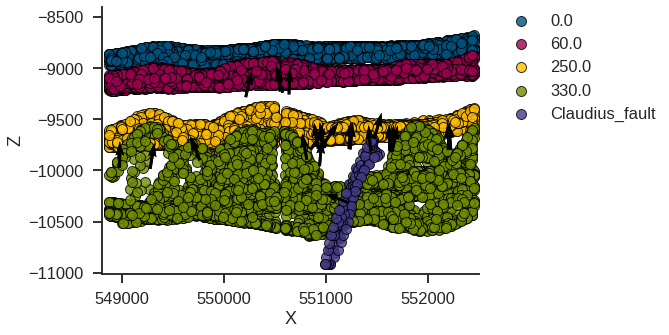

In [17]:
gp.plot.plot_data(geo_model, direction='y')

By default all surfaces belong to one unique series.

In [9]:
geo_model.surfaces

,surface,series,order_surfaces,isBasement,color,id
0,0,Default series,1,False,#015482,1
1,60,Default series,2,False,#9f0052,2
2,250,Default series,3,False,#ffbe00,3
3,330,Default series,4,False,#728f02,4
4,Claudius_fault,Default series,5,False,#443988,5
5,basement,Basement,1,True,#ff3f20,6


We will need to separate with surface belong to each series:

In [18]:
gp.map_series_to_surfaces(geo_model, {'Default series':(0.0, 60.0, 250.0),
                                      'Fault':'Claudius_fault',
                                      'Uncomformity':330,
                                      })


,surface,series,order_surfaces,isBasement,color,id
0,0,Default series,1,False,#015482,1
1,60,Default series,2,False,#9f0052,2
2,250,Default series,3,False,#ffbe00,3
4,Claudius_fault,Fault,1,False,#443988,4
3,330,Uncomformity,1,False,#728f02,5
5,basement,Basement,1,True,#ff3f20,6


So far we did not specify which series/faults are actula faults:

In [19]:
geo_model.set_is_fault('Fault')

Fault colors changed. If you do not like this behavior, set change_color to False.


,isFault,isFinite
Default series,False,False
Fault,True,False
Uncomformity,False,False
Basement,False,False


Ordering the events from younger to older:

In [20]:
geo_model.reorder_series(['Default series', 'Fault', 'Uncomformity', 'Basement'])

,order_series,BottomRelation
Default series,1,Erosion
Fault,2,Fault
Uncomformity,3,Erosion
Basement,4,Erosion


Check which series/faults are affected by other faults (rows offset columns):

In [21]:
geo_model.faults.faults_relations_df

,Default series,Fault,Uncomformity,Basement
Default series,False,False,False,False
Fault,False,False,True,True
Uncomformity,False,False,False,False
Basement,False,False,False,False


Now we are good to go:

In [22]:
gp.set_interpolation_data(geo_model, theano_optimizer='fast_run',
                          compile_theano=True)

Compiling theano function...
Level of Optimization:  fast_run
Device:  cuda
Precision:  float32
Number of faults:  1
Compilation Done!


In [23]:
gp.compute_model(geo_model)


Lithology ids 
  [5. 5. 5. ... 1. 1. 1.] 

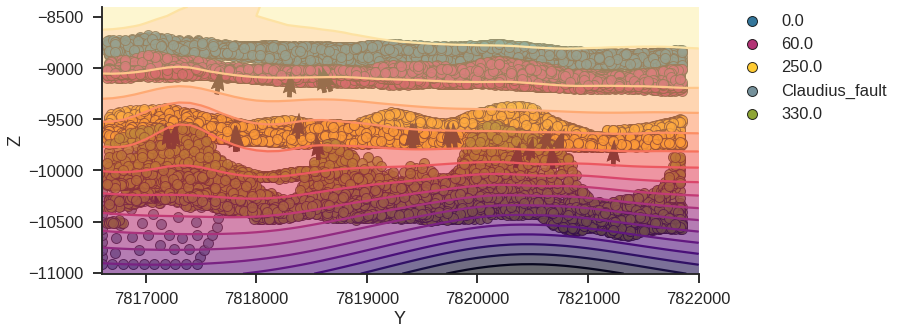

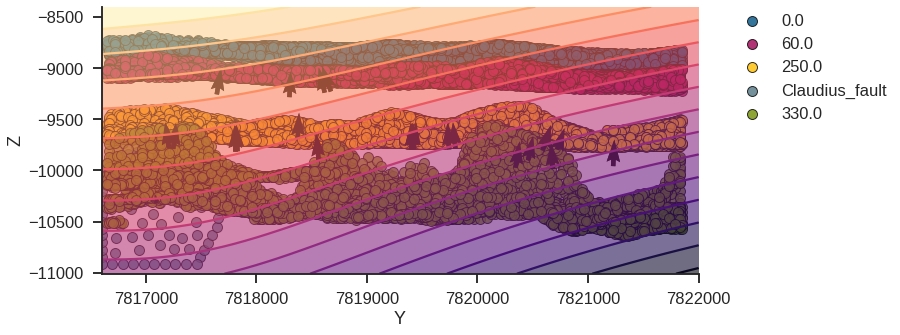

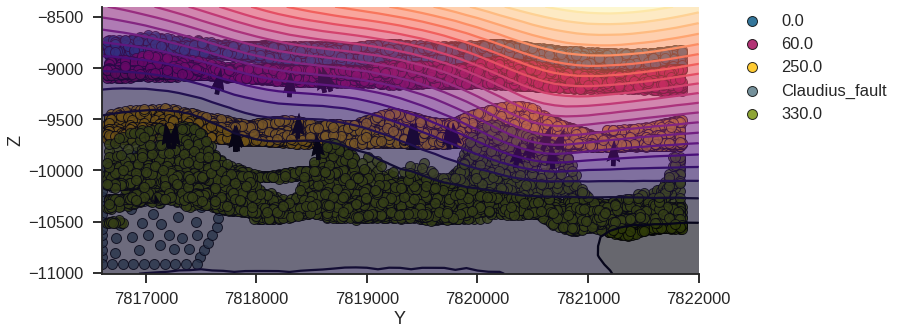

In [24]:
sect = 5
gp.plot.plot_scalar_field(geo_model, sect, series=0, direction='x')
gp.plot.plot_scalar_field(geo_model, sect, series=1, direction='x')
gp.plot.plot_scalar_field(geo_model, sect, series=2, direction='x')

../../../gempy/plot/visualization_2d.py:242: UserWarning: No contour levels were found within the data range.
  colors=self._cmap.colors[f_id], linestyles='solid')


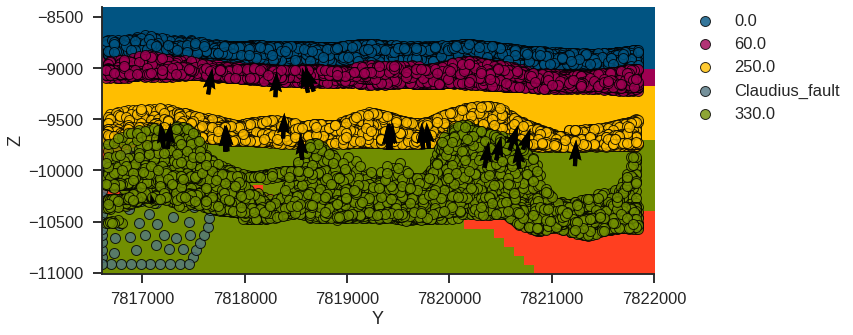

In [25]:
gp.plot.plot_section(geo_model, sect, show_data=True, direction='x')

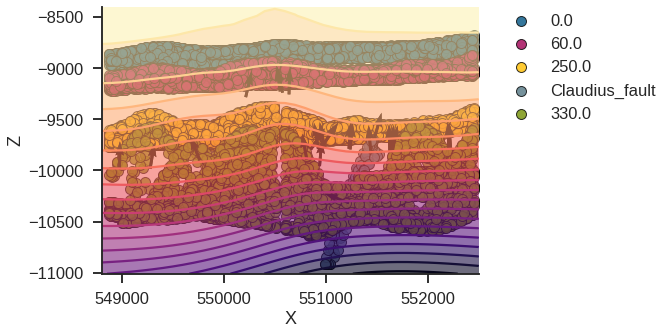

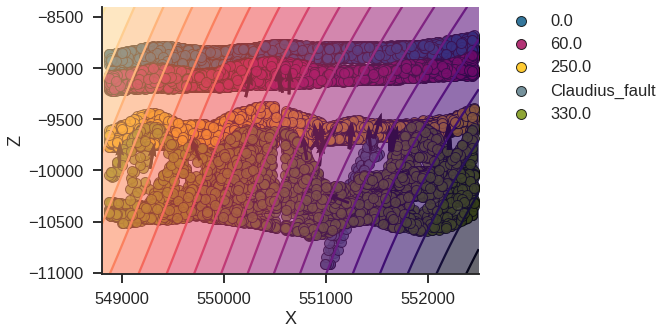

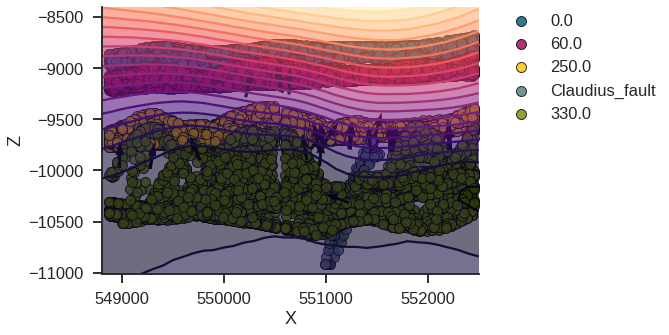

In [26]:
gp.plot.plot_scalar_field(geo_model, 25, series=0, direction='y')
gp.plot.plot_scalar_field(geo_model, 25, series=1, direction='y')
gp.plot.plot_scalar_field(geo_model, 25, series=2, direction='y')

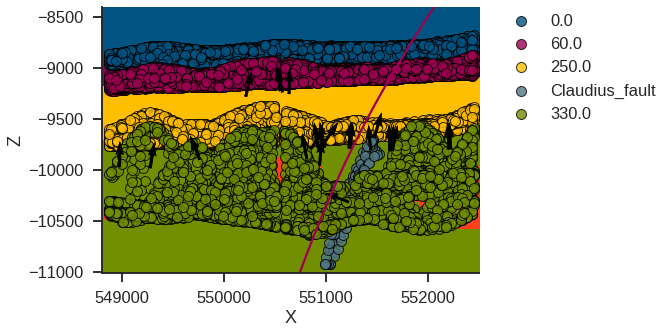

In [27]:
gp.plot.plot_section(geo_model, 25, show_data=True, direction='y')

In [ ]:
# gp.plot.plot_3D(geo_model, render_data=True)

![foo](Claudius.png)

## Timing:


### Fault
#### Dense 20k input, 62k voxels

- CPU Memory 8 Gb 44.9 s ± 150 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
- GPU Memory 6.8 gb:
   + 2.13 s ± 3.39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
           + steps __str__ = [64.56394268]
           + steps __str__ = [9927.69441126]
           + steps __str__ = [196.15202667]
       
  + 1.13 s ± 2.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
  
        + steps __str__ = [645.63943742]
        + steps __str__ = [99276.94573919]
        + steps __str__ = [1961.52029888]